In [41]:
from proteome_tools_research.dataset import *
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import itertools
import numpy as np
import random

# Overlap Pools

In [42]:
df = load_dataframe(r"D:\merged_experiment.txt")

In [43]:
calibration_peptides = get_calibration_peptides(df)
calibration_peptides = list(calibration_peptides.keys())
df = df[~df["Modified sequence"].isin(calibration_peptides)]

## Within pool

In [44]:
overlap_within_pool = df.groupby(['Modified sequence', 'pool']).size().reset_index(name='count')

In [45]:
overlap_within_pool['count'].describe()

count    327790.000000
mean          4.991986
std           6.129774
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         820.000000
Name: count, dtype: float64

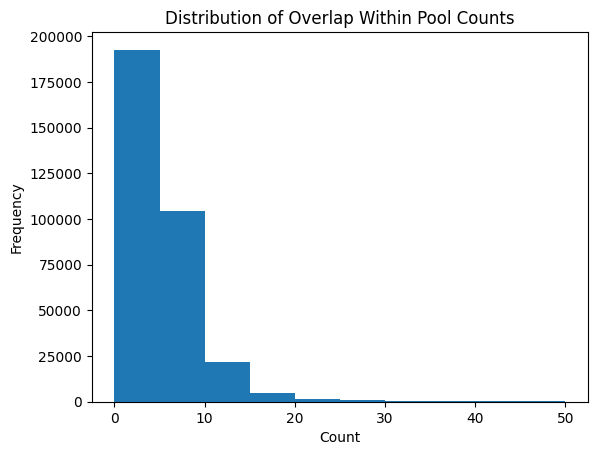

In [46]:
overlap_within_pool["count"].plot.hist(range=(0, 50))
plt.title("Distribution of Overlap Within Pool Counts")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

## Different pool

In [47]:
interaction_matrix = pd.crosstab(df['Modified sequence'], df['pool'])

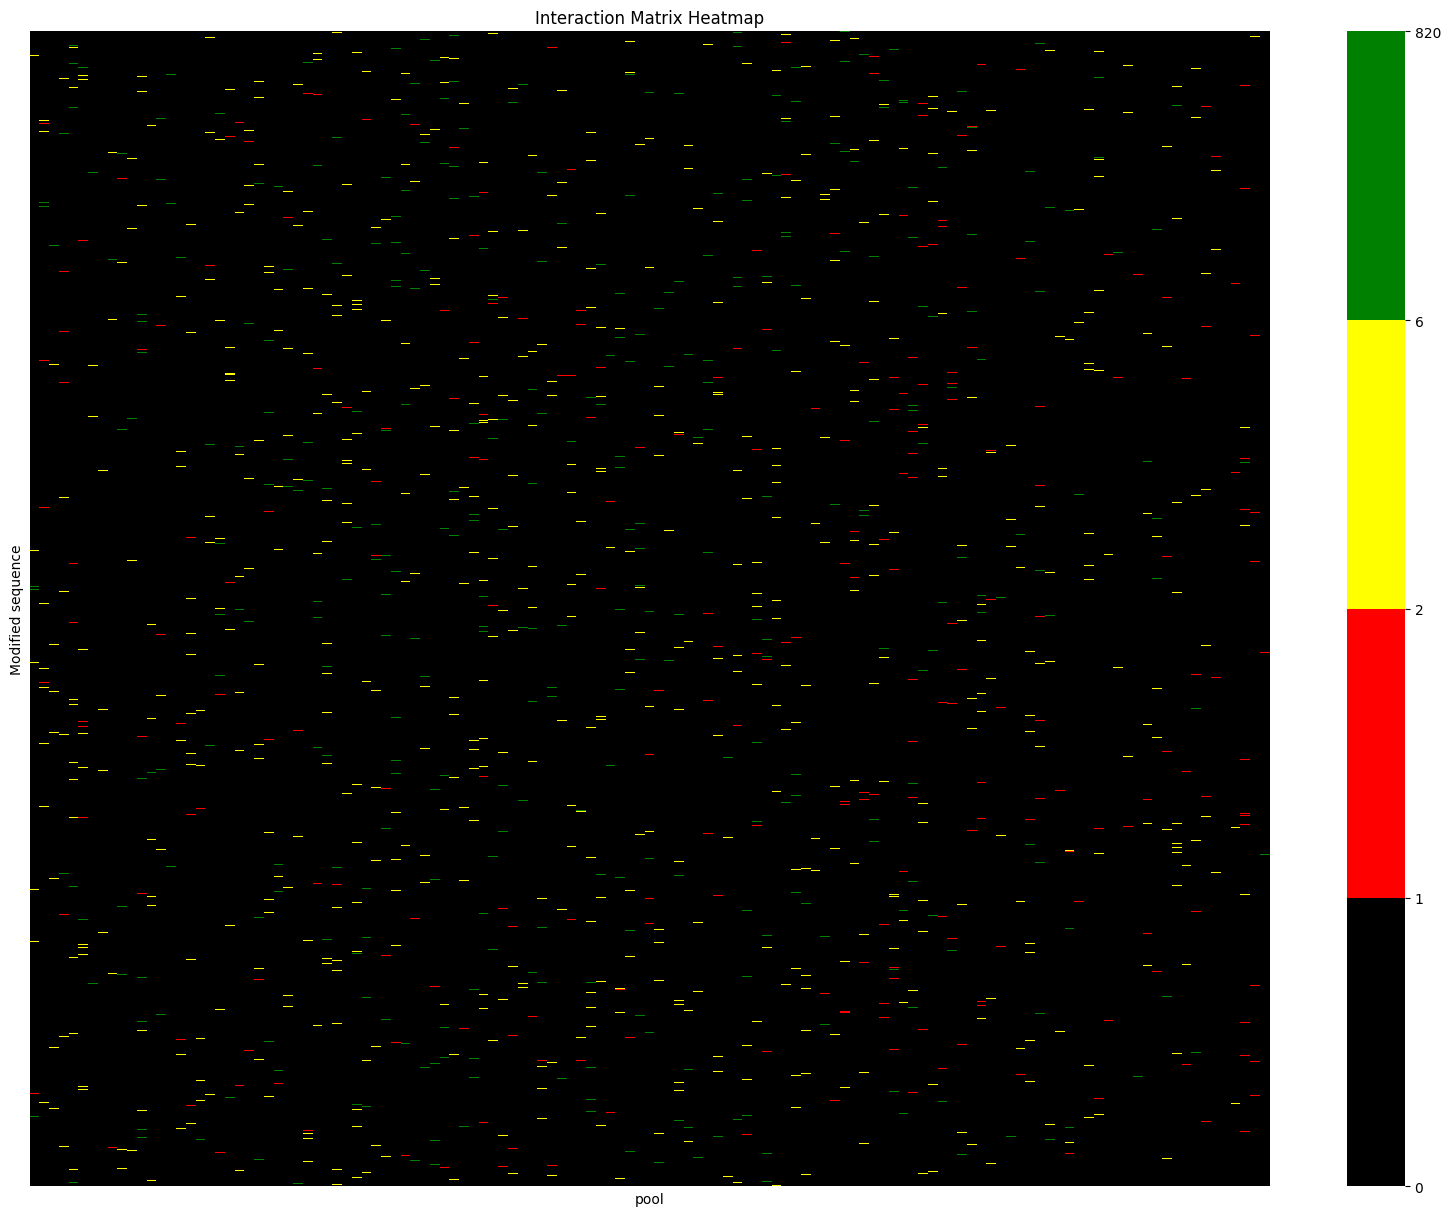

In [48]:
# Define the custom colormap
cmap = ListedColormap(['black', 'red', 'yellow', 'green'])

# Define boundaries for each color (to include intervals properly)
bounds = [0, 1, 2, 6, interaction_matrix.max().max()]  # 0, 1, 2-5, 6+ defined
norm = BoundaryNorm(bounds, cmap.N)

# Set up the figure size
plt.figure(figsize=(20, 15))

# Create the heatmap with the specified colormap and norm for custom value mapping
sns.heatmap(interaction_matrix, cmap=cmap, norm=norm, cbar=True, xticklabels=False, yticklabels=False)

# Add title for better readability
plt.title('Interaction Matrix Heatmap')

# Show the plot
plt.show()

In [49]:
unique_pools_per_sequence = df.groupby('Modified sequence')['pool'].nunique().reset_index()
unique_pools_per_sequence.columns = ['Modified sequence', 'Unique pools']


In [50]:
unique_pools_per_sequence.describe()

,Unique pools
count,292221.000000
mean,1.121720
std,1.886349
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,127.000000


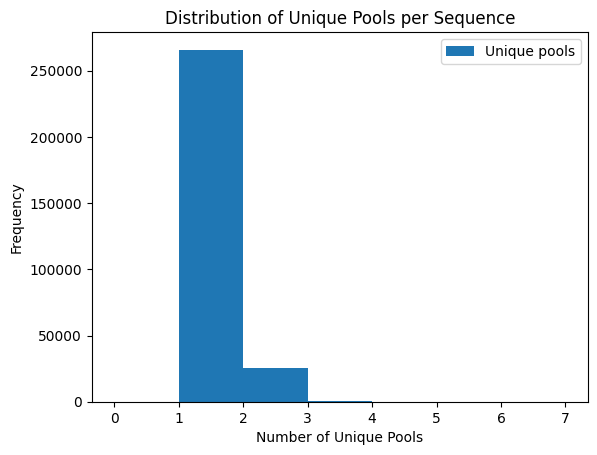

In [51]:
unique_pools_per_sequence.plot.hist(bins=[0, 1, 2, 3, 4, 5, 6, 7], range=(0, 7))
plt.title("Distribution of Unique Pools per Sequence")
plt.xlabel("Number of Unique Pools")
plt.ylabel("Frequency")
plt.show()

# Calculating Mean absolute deviation

In [52]:
def mean_absolute_deviation(series,threshhold):
    if len(series)<threshhold:
        return None
    return (series - series.mean()).abs().mean()

In [53]:
def pairwise_diff_mean(series):
    if len(series)<2:
        return None
    # Generate all pairwise differences
    differences = [abs(a - b) for a, b in itertools.combinations(series, 2)]
    
    # Return the mean of the differences
    return np.mean(differences)

In [54]:
cal_peptides = list(get_calibration_peptides(df).keys())
df_no_calbration_pep = df[~df['Modified sequence'].isin(cal_peptides)]

## Within pool

In [55]:
# Group by peptide sequence and pool, then calculate the variance of 'Score'
within_pool_mad = df.groupby(['Modified sequence', 'pool'])['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x),
                                                                      pairwise_diff_pairs = lambda x: pairwise_diff_mean(x) if len(x)==2 else None)

## Across pools

### Option 1 Also include peptides in same pool

In [56]:
across_pool_mad_1 = df_no_calbration_pep.groupby('Modified sequence')['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x),
                                                                    pairwise_diff_pairs = lambda x: pairwise_diff_mean(x) if len(x)==2 else None)

### Option 2: Take mean of iRT each peptide in pool get mean absolute deviation across pools

In [57]:
pool_peptide_means = df_no_calbration_pep.groupby(['Modified sequence', 'pool'])['iRT'].agg(lambda x: x.mean()).dropna()
pool_peptide_means = pool_peptide_means.reset_index(name="iRT")

In [58]:
across_pool_mad_2 = pool_peptide_means.groupby('Modified sequence')['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x),
                                                                    pairwise_diff_pairs = lambda x: pairwise_diff_mean(x) if len(x)==2 else None)

### Option 3: Sample a iRT each peptide in each pool use this to get mean absolute deviation accros pools

In [59]:
pool_peptide_samples = df_no_calbration_pep.groupby(['Modified sequence', 'pool'])['iRT'].agg(lambda x: np.random.choice(x)).dropna()
pool_peptide_samples = pool_peptide_samples.reset_index(name="iRT")

In [60]:
across_pool_mad_3 = pool_peptide_samples.groupby('Modified sequence')['iRT'].agg(mad = lambda x: mean_absolute_deviation(x, 2),
                                                                      mad_pairs = lambda x: mean_absolute_deviation(x, 2) if len(x)==2 else None,
                                                                    pairwise_diff = lambda x: pairwise_diff_mean(x),
                                                                    pairwise_diff_pairs = lambda x: pairwise_diff_mean(x) if len(x)==2 else None)

## Compare

In [61]:
test = pd.concat([within_pool_mad.mean(),across_pool_mad_1.mean(),across_pool_mad_2.mean(),across_pool_mad_3.mean()])


<Figure size 1000x600 with 0 Axes>

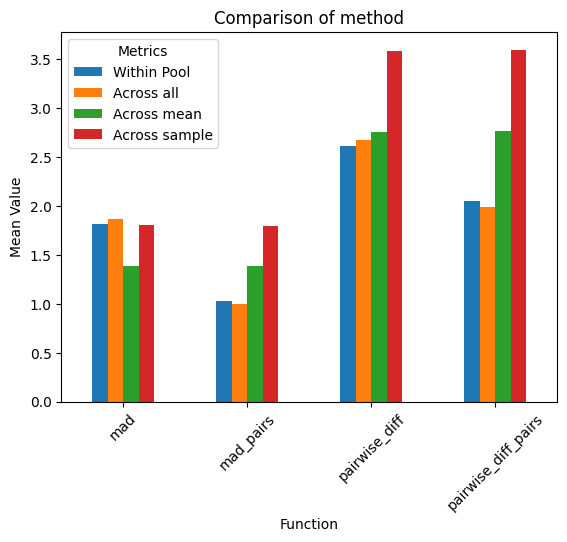

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `test` contains the concatenated means with index labels.
concatenated_pool_stats = pd.concat([
    within_pool_mad.mean().rename("Within Pool"),
    across_pool_mad_1.mean().rename("Across all"),
    across_pool_mad_2.mean().rename("Across mean"),
    across_pool_mad_3.mean().rename("Across sample")
], axis=1)

# Plot
plt.figure(figsize=(10, 6))
concatenated_pool_stats.plot(kind='bar')
plt.xlabel('Function')
plt.ylabel('Mean Value')
plt.title('Comparison of method')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

<Figure size 1000x600 with 0 Axes>

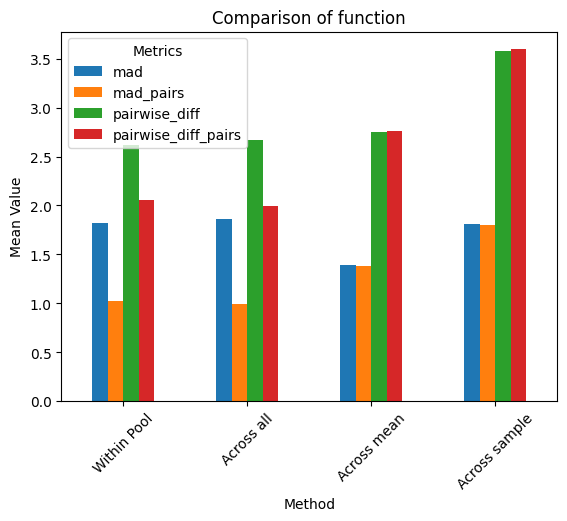

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
concatenated_pool_stats.T.plot(kind='bar')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Comparison of function')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()

# Inspecting interesting peptides

In [64]:
##TODO TESTING REMOVE LATER
#df = load_dataframe("testing/data_small_merged_experiment")
#unique_pools_per_sequence = df.groupby('Modified sequence')['pool'].nunique().reset_index()
#unique_pools_per_sequence.columns = ['Modified sequence', 'Unique pools']

In [65]:
def convert_dictionary_plotting(dictionary):
    # Convert the group_by_file dictionary into a list of dictionaries
    converted_dictionary = []
    for (sequence, value), iRTs in dictionary.items():
        # Check if the sequence is already in the result list
        sequence_entry = next((item for item in converted_dictionary if item['sequence'] == sequence), None)
        if not sequence_entry:
            # If not, add it
            sequence_entry = {'sequence': sequence, "combined": {}}
            converted_dictionary.append(sequence_entry)
        # Add the experiment and its iRT list to the sequence entry
        sequence_entry["combined"][value] = iRTs
    return converted_dictionary

In [66]:
def plot_kde_dictionary(dictionary,threshhold,legend=None):
    for entry in dictionary:
        sequence = entry['sequence']
        combined = entry["combined"]
        plt.figure(figsize=(8, 6))
        
        for key, values in combined.items():
            if len(values) >= threshhold:  # KDE requires at least two data points
                label = f"{key} (n={len(values)})"  # Label includes the number of data points
                sns.kdeplot(values, label=label, fill=False)
        
        plt.xlabel("Retention Time")
        plt.ylabel("Density")
        if legend:
            plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"KDE Plot for Sequence: {sequence}")
        plt.show()

In [67]:
top_10_sequences = unique_pools_per_sequence.nlargest(10, 'Unique pools')['Modified sequence']
selected_sequences = df[df['Modified sequence'].isin(top_10_sequences)]
selected_sequences = selected_sequences[selected_sequences['pool'] != 131]

#selected_sequences = df[df['Modified sequence'].isin(top_10_sequences) & (df['pool'] != 131)]

## Files

In [68]:
group_by_file = selected_sequences.groupby(['Modified sequence', 'Experiment'])['iRT'].apply(list).to_dict()


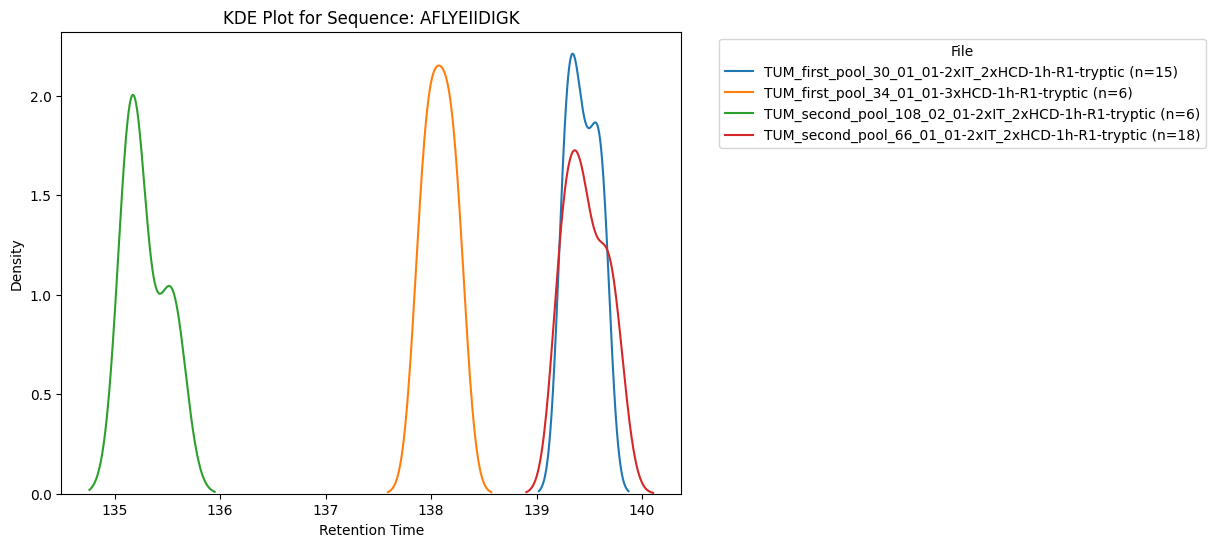

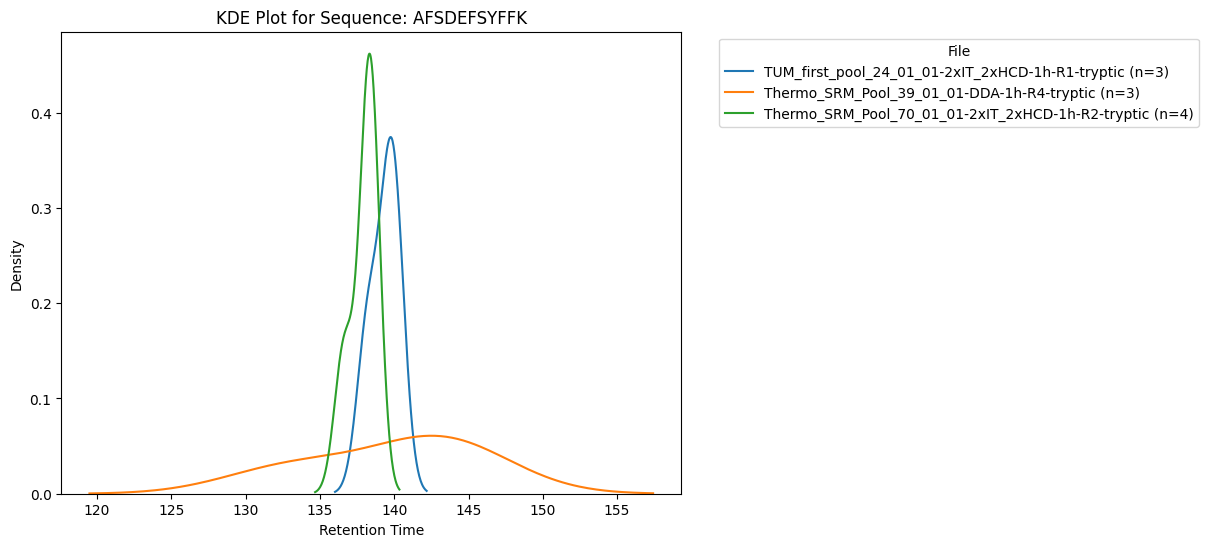

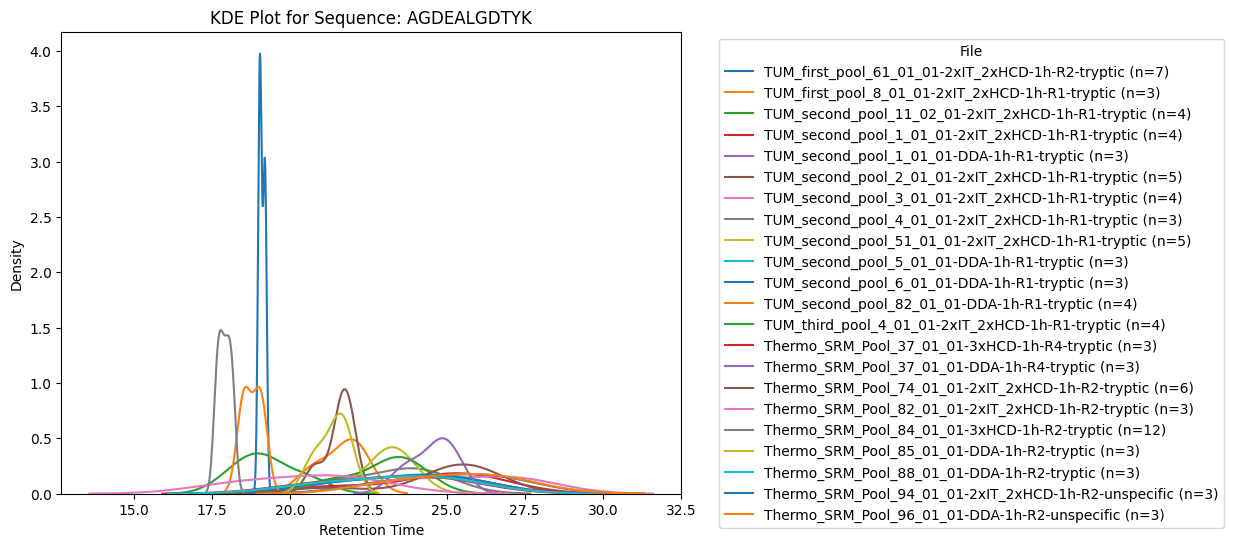

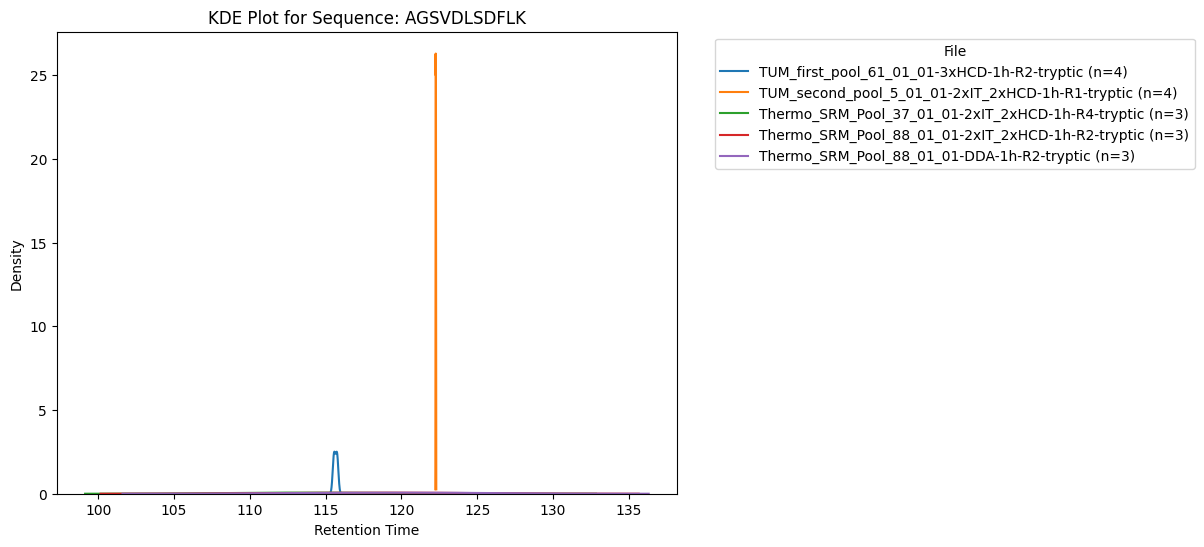

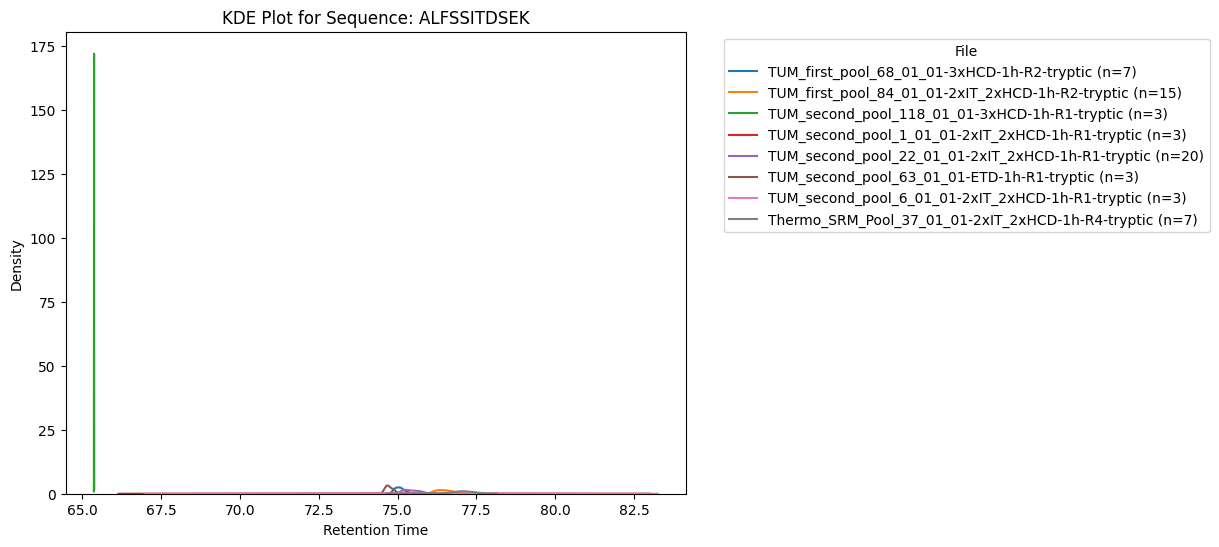

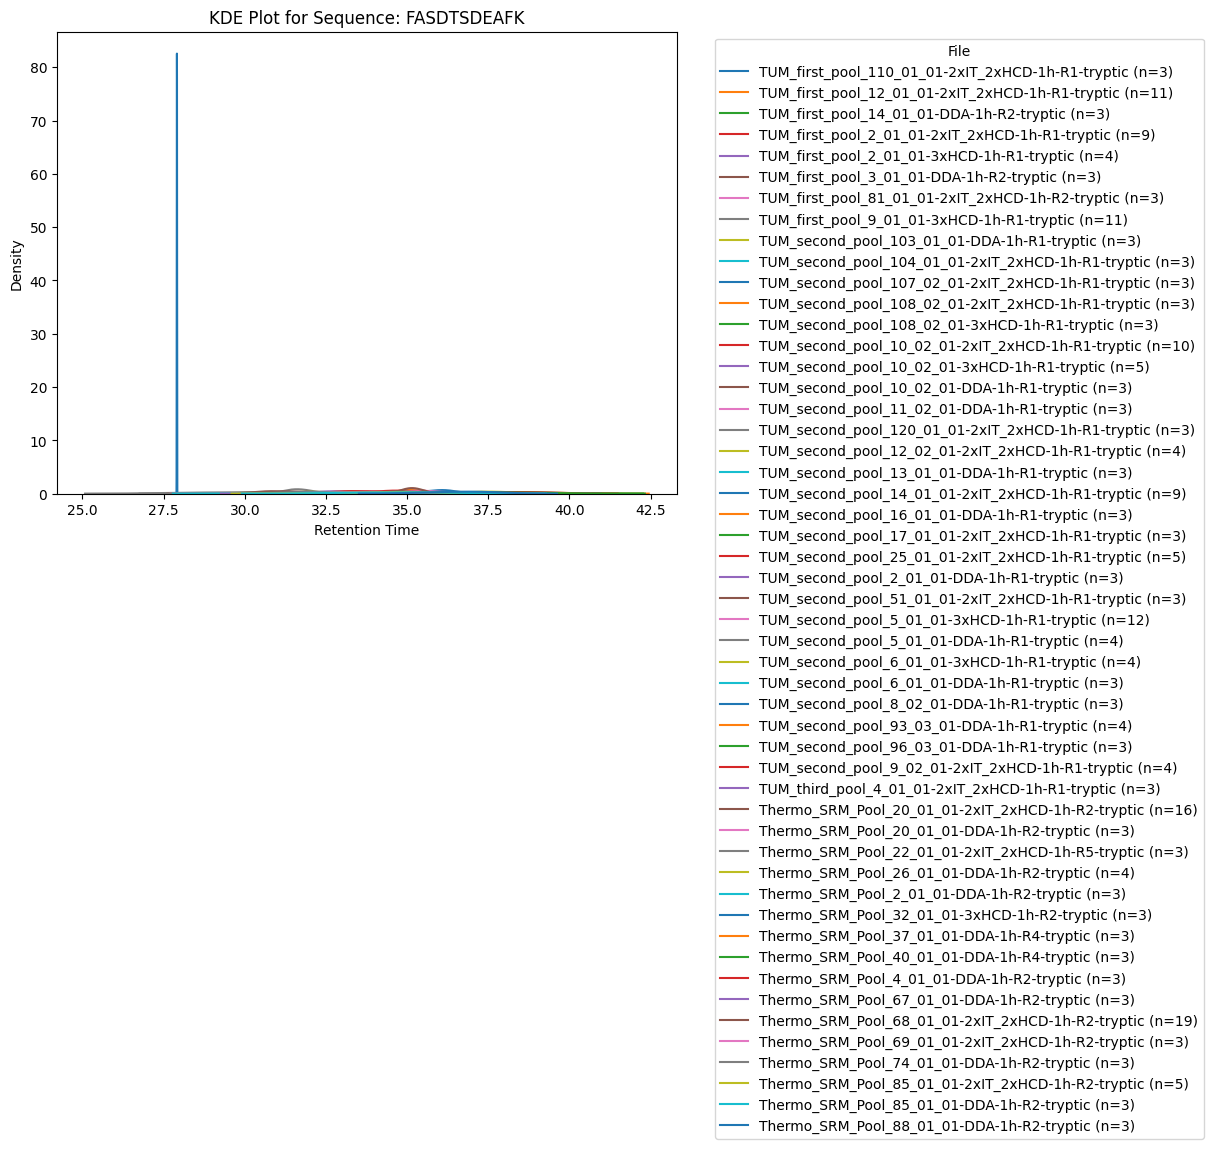

C:\Users\lambe\AppData\Local\Temp\ipykernel_11676\1892831864.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')


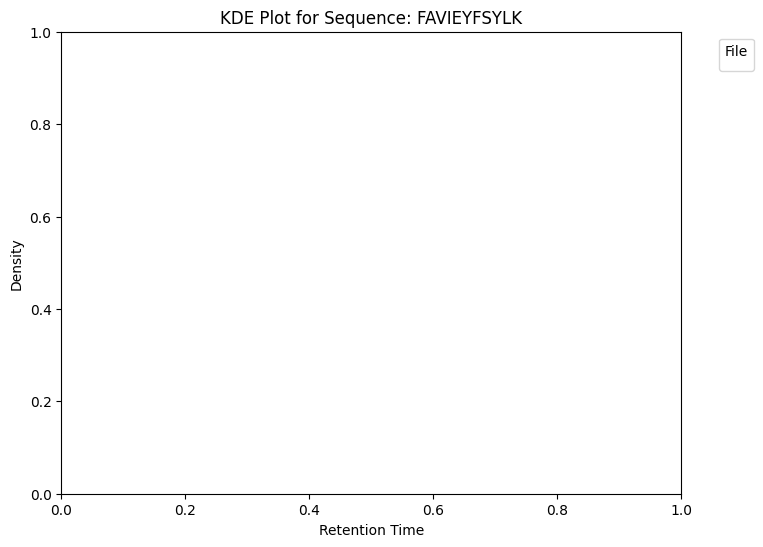

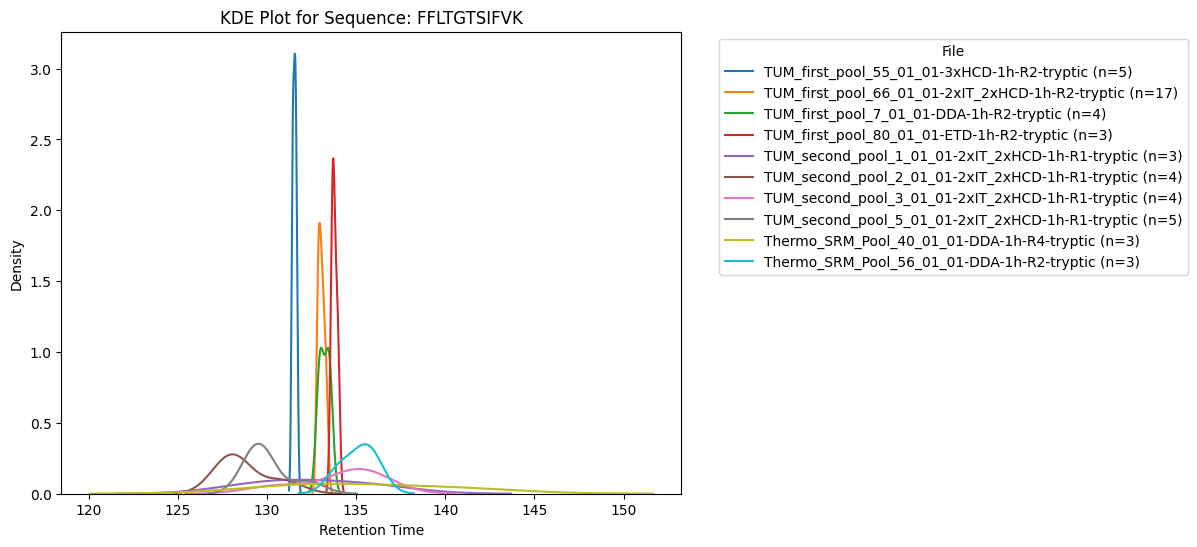

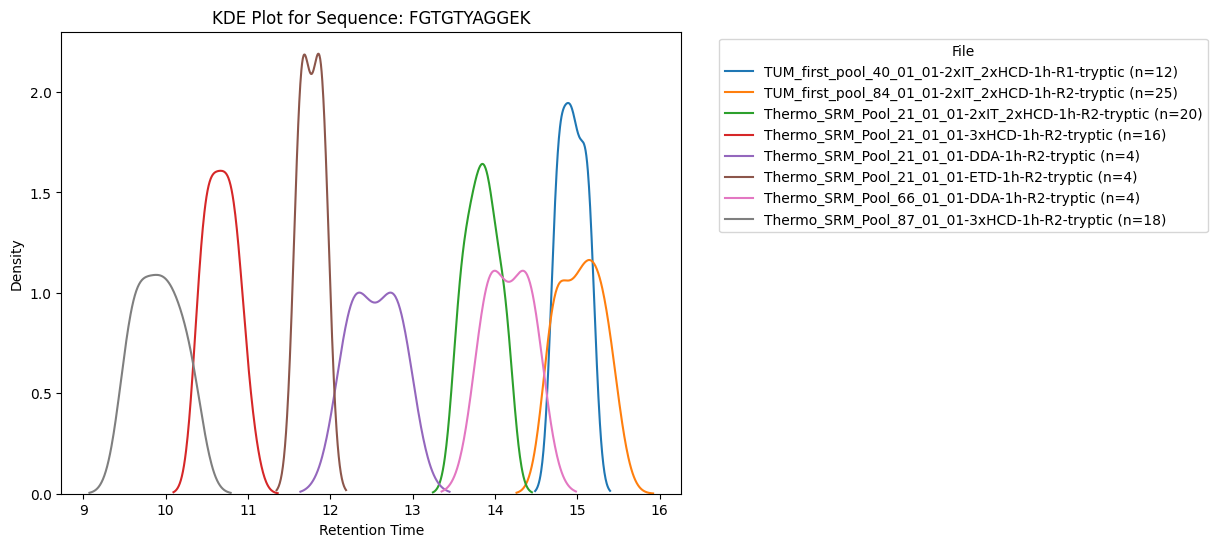

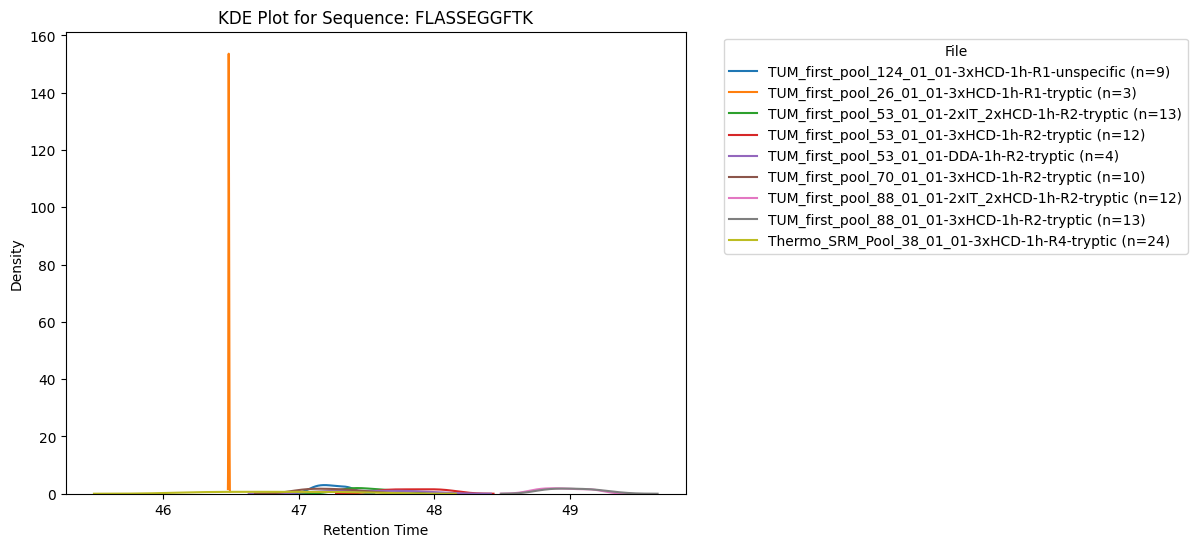

In [69]:
dic_files = convert_dictionary_plotting(group_by_file)
plot_kde_dictionary(dic_files,3,"File")

## Pools all

In [70]:
group_by_pool = selected_sequences.groupby(['Modified sequence', 'pool'])['iRT'].apply(list).to_dict()


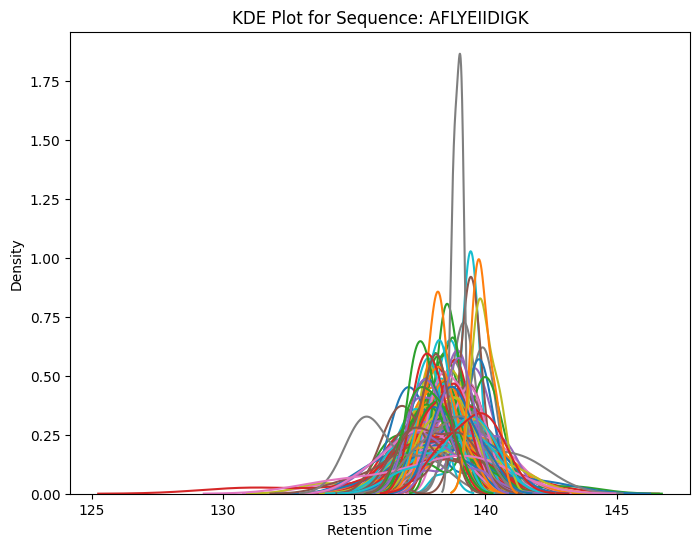

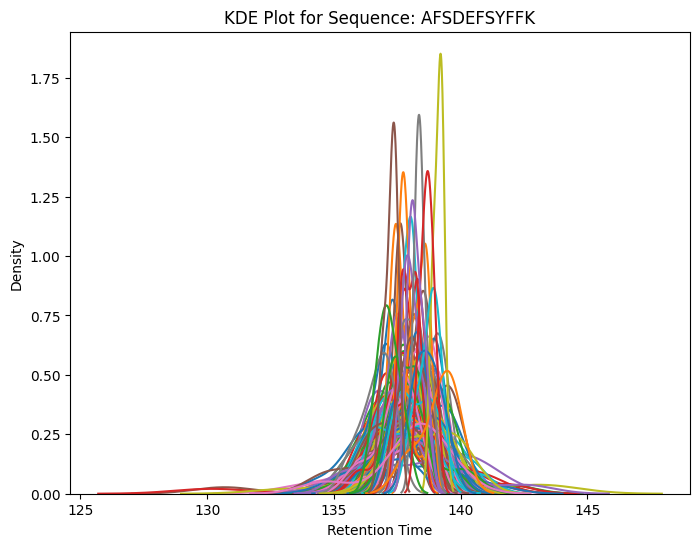

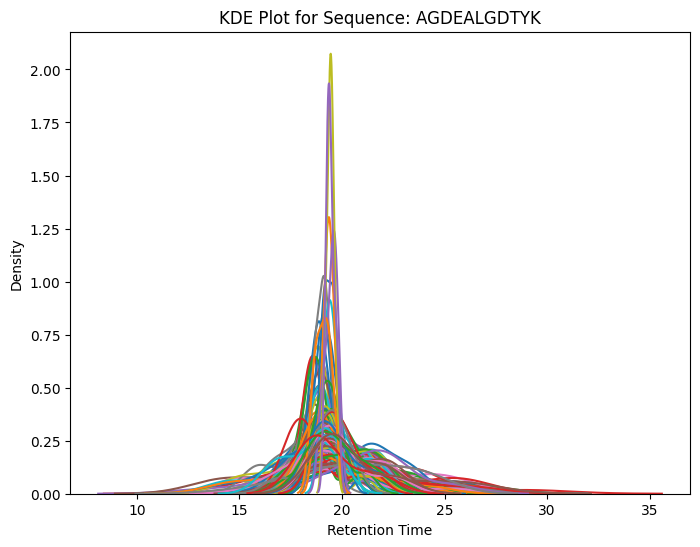

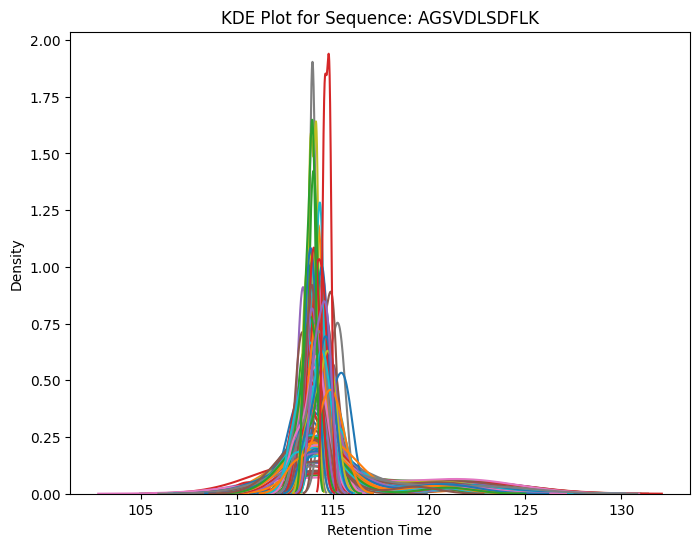

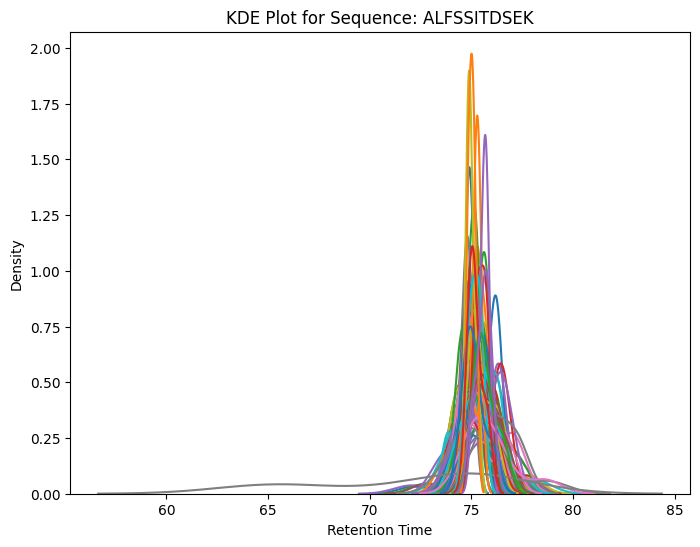

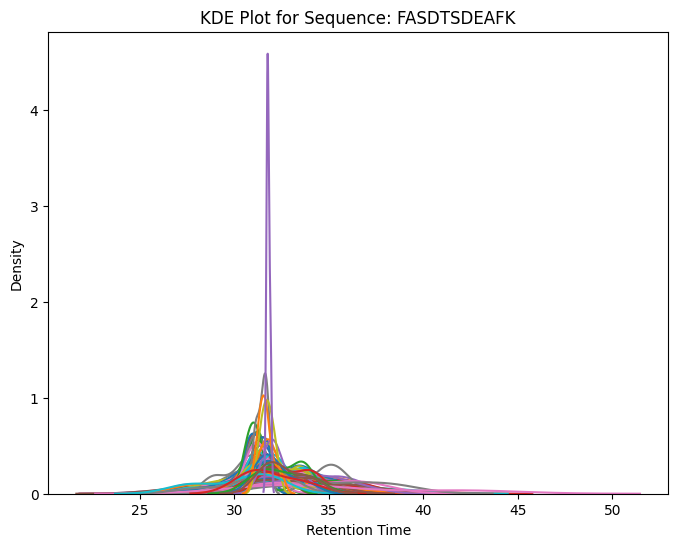

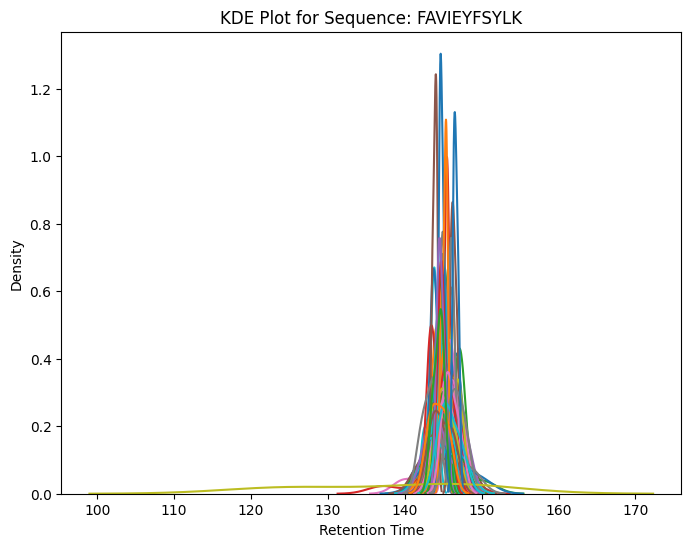

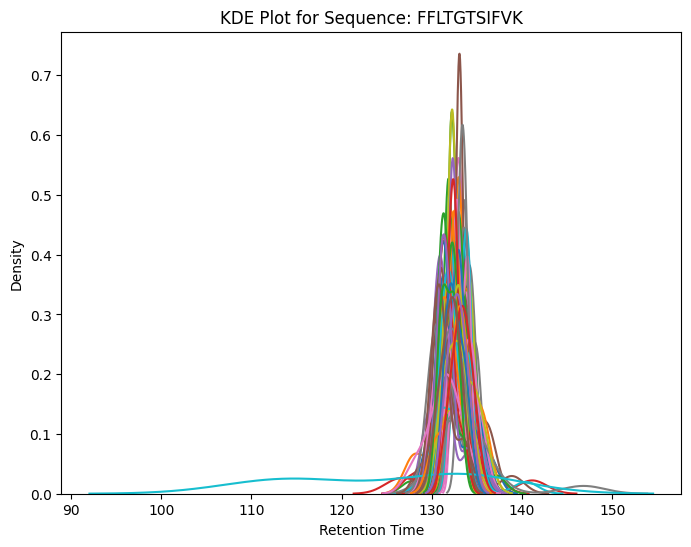

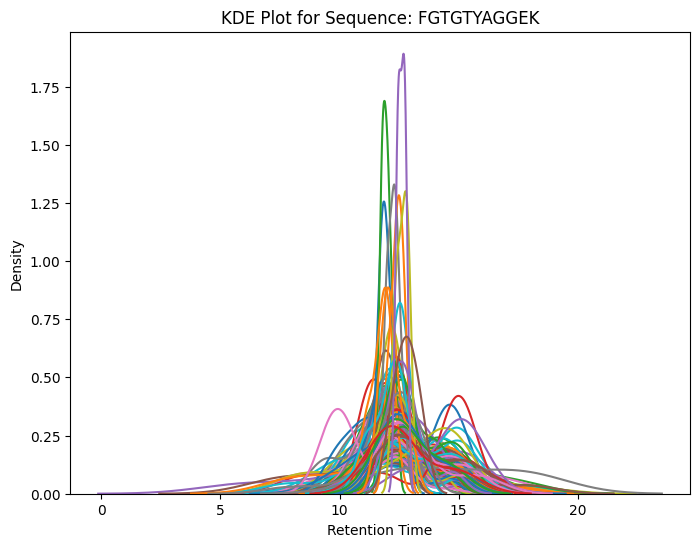

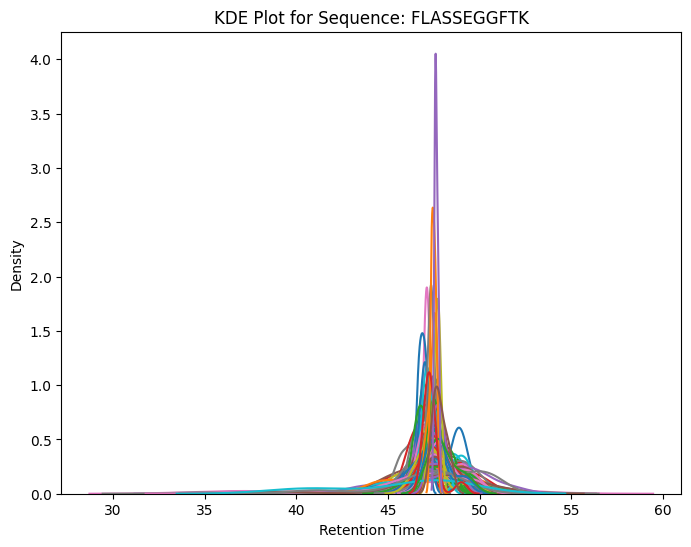

In [71]:
dic_pool = convert_dictionary_plotting(group_by_pool)
plot_kde_dictionary(dic_pool,3)

## Pools sample

In [72]:
pools_listing = random.sample(range(1, 128), 5)
print(pools_listing)
selected_sequences_sampled = selected_sequences[selected_sequences["pool"].isin(pools_listing)]

[58, 79, 112, 36, 32]


In [73]:
group_by_pool = selected_sequences_sampled.groupby(['Modified sequence', 'pool'])['iRT'].apply(list).to_dict()

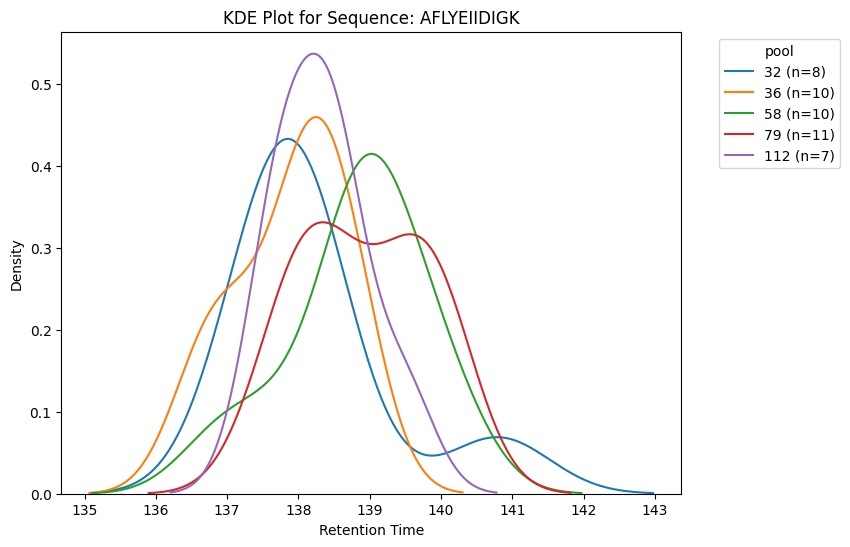

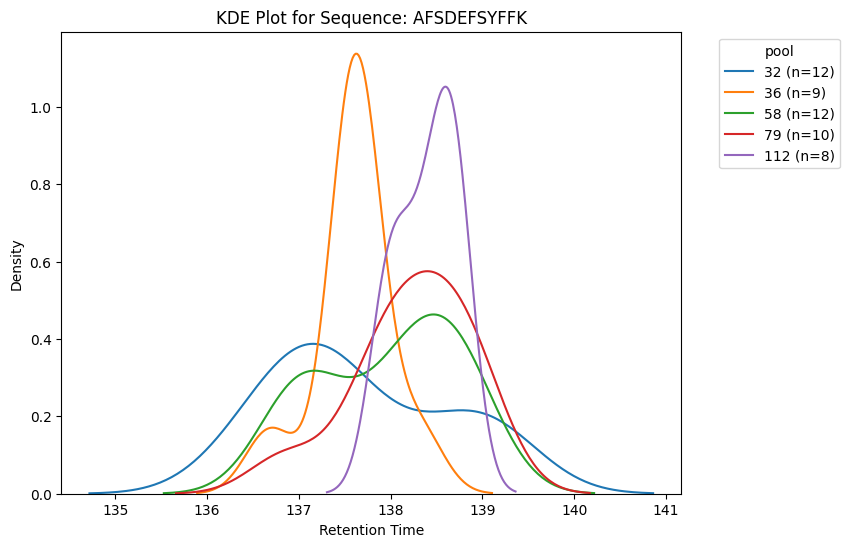

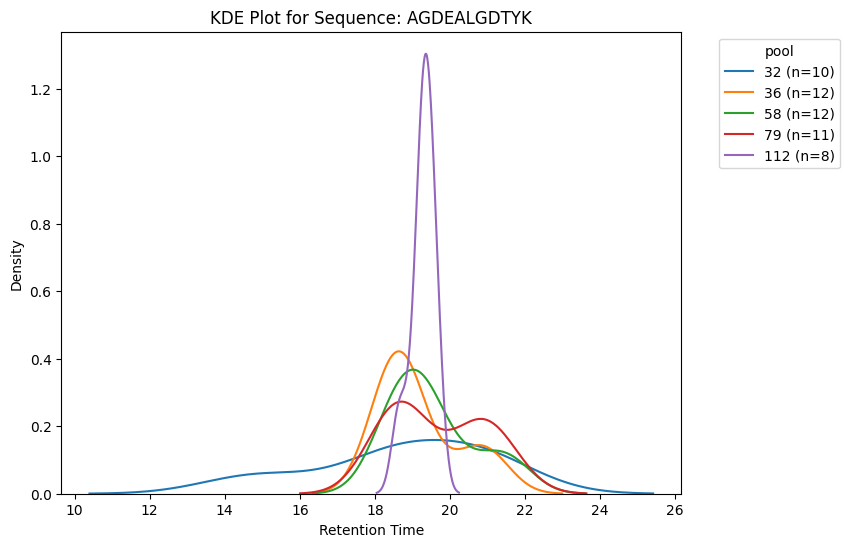

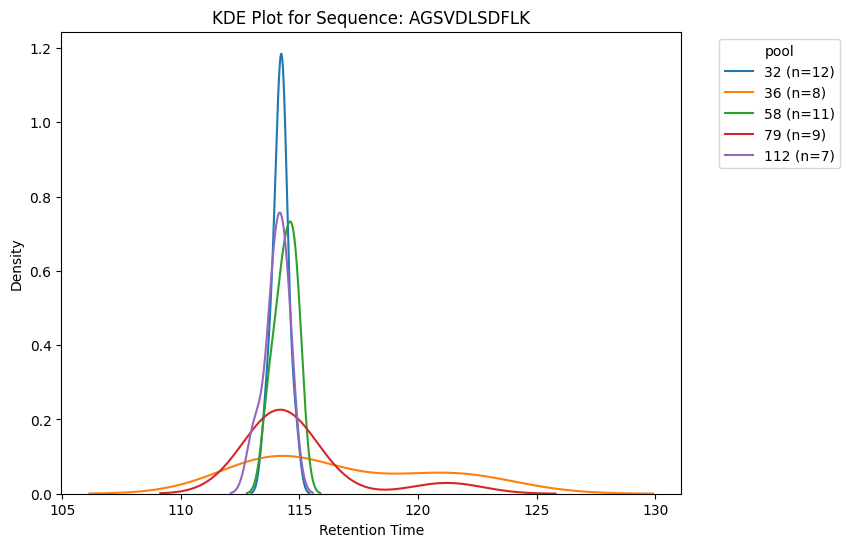

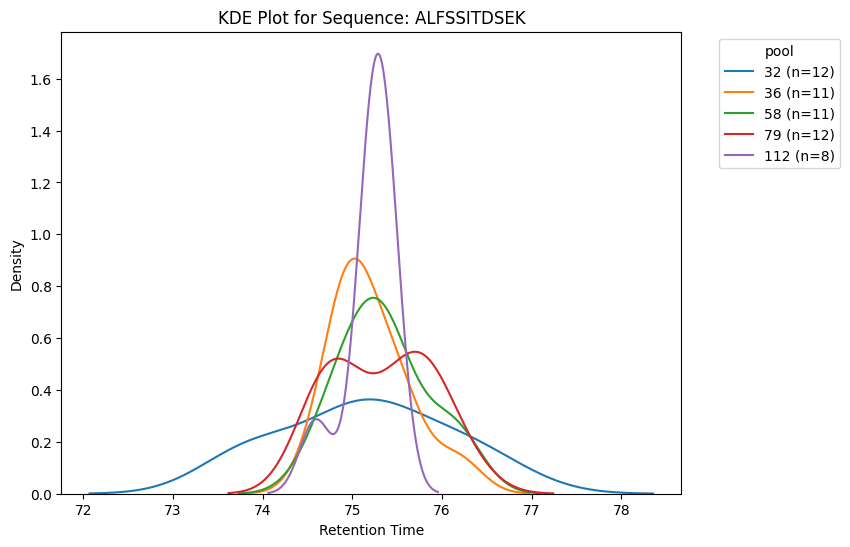

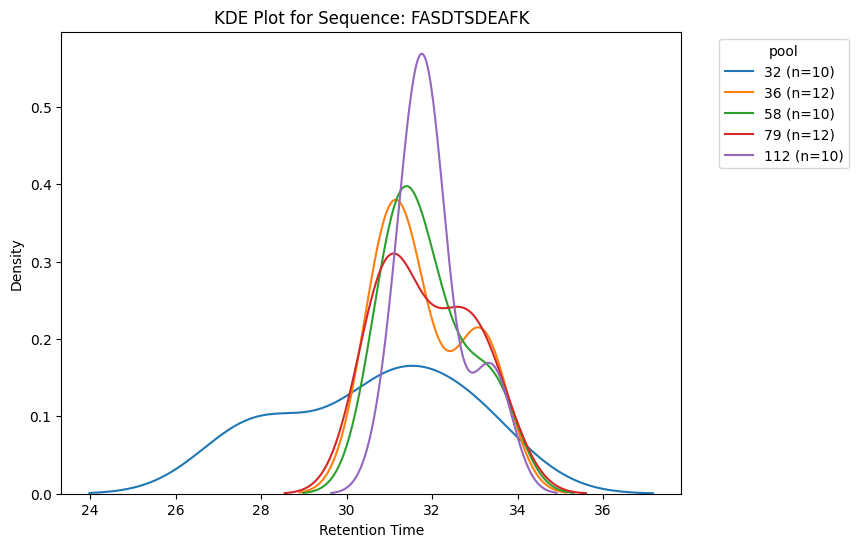

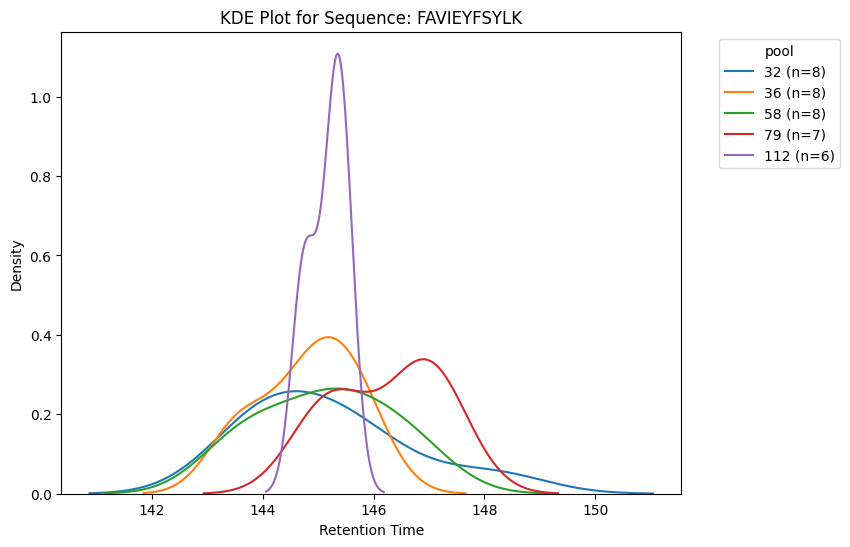

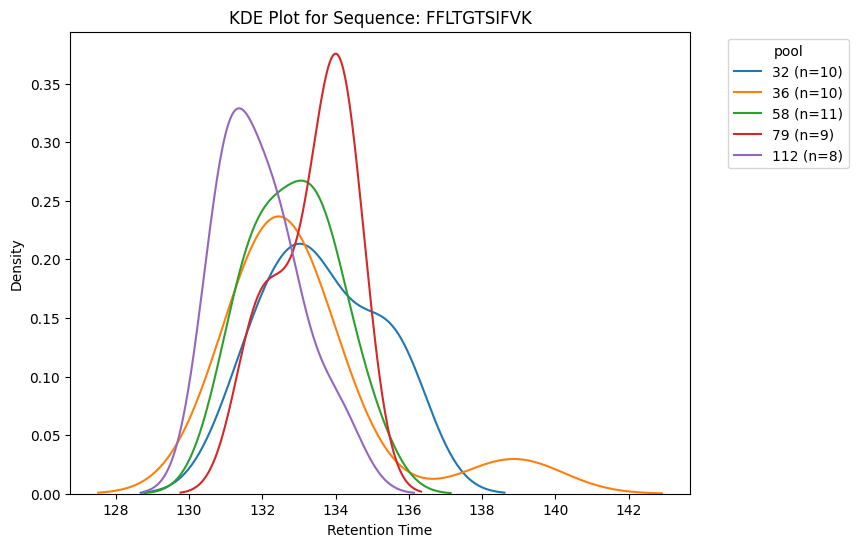

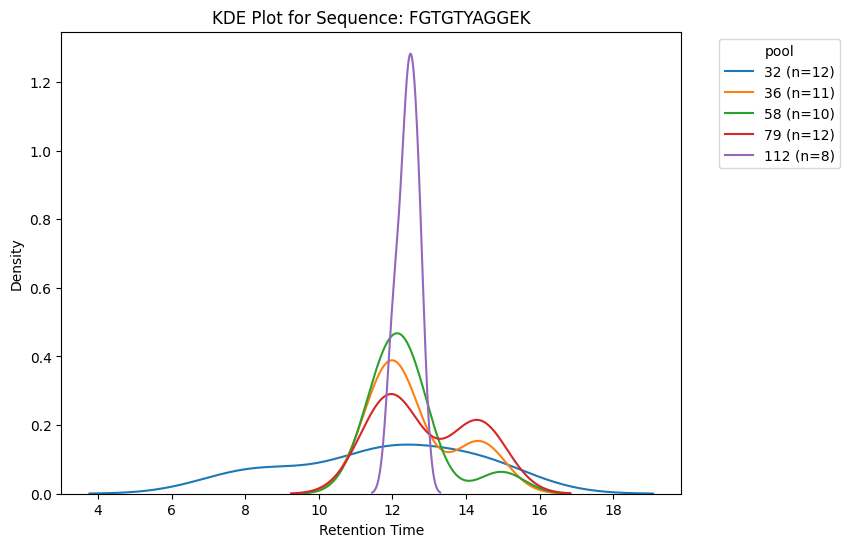

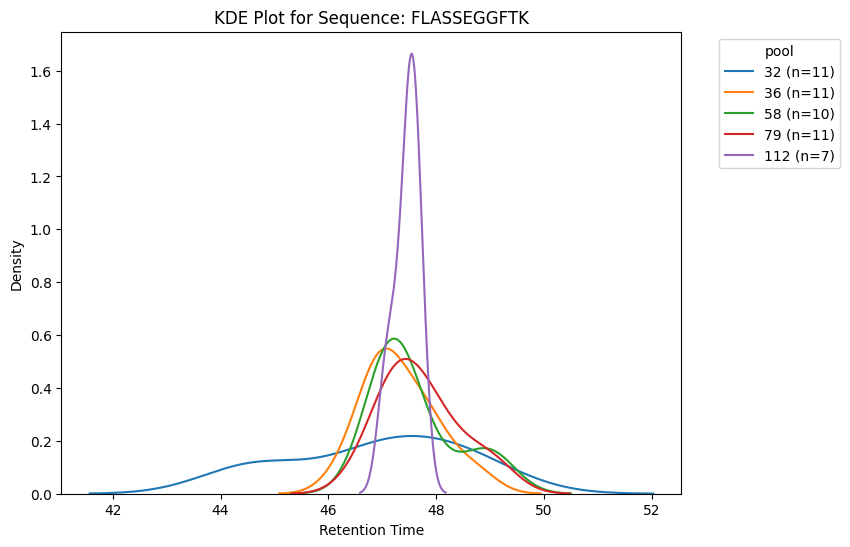

In [74]:
dic_pool = convert_dictionary_plotting(group_by_pool)
plot_kde_dictionary(dic_pool,3,"pool")

## selected sequences

In [75]:
selected = unique_pools_per_sequence[(unique_pools_per_sequence["Unique pools"] >= 10) & (unique_pools_per_sequence["Unique pools"] <= 30)]["Modified sequence"]
selected

51399       EHISSDYAGK
73513       FSDEFSYFFK
101555      HWYITTGPVR
107438     IHTGEKPYECK
202350       PYECNECGK
228109      SLGEHEGGGK
245010    TFAHTESHISKH
Name: Modified sequence, dtype: object

In [76]:
selected = df[df['Modified sequence'].isin(selected)]


In [77]:
group_by_pool = selected.groupby(['Modified sequence', 'pool'])['iRT'].apply(list).to_dict()

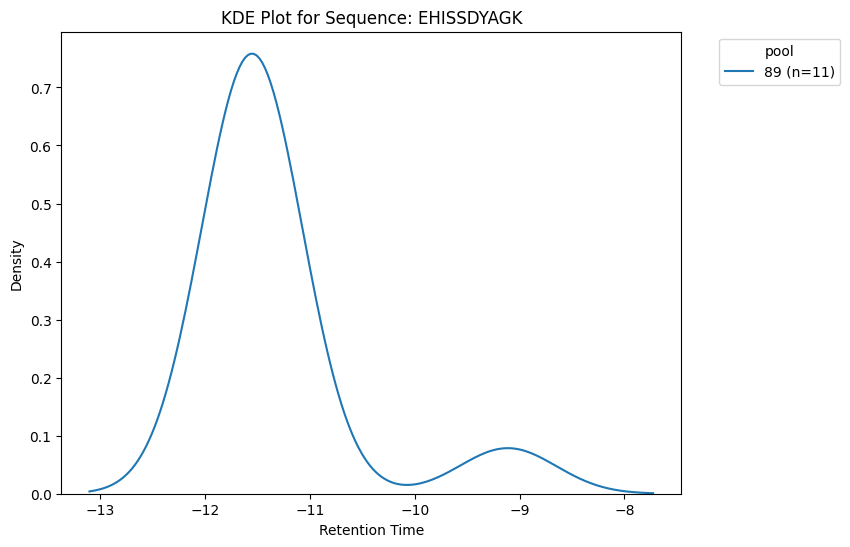

C:\Users\lambe\AppData\Local\Temp\ipykernel_11676\1892831864.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')


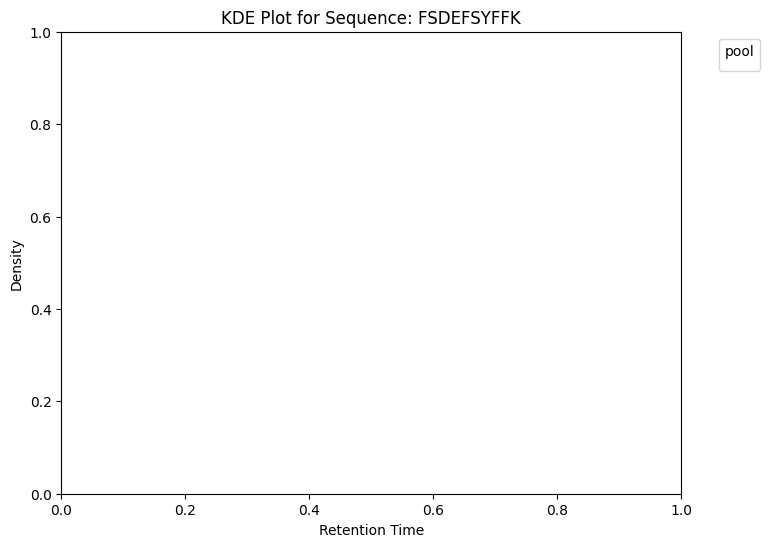

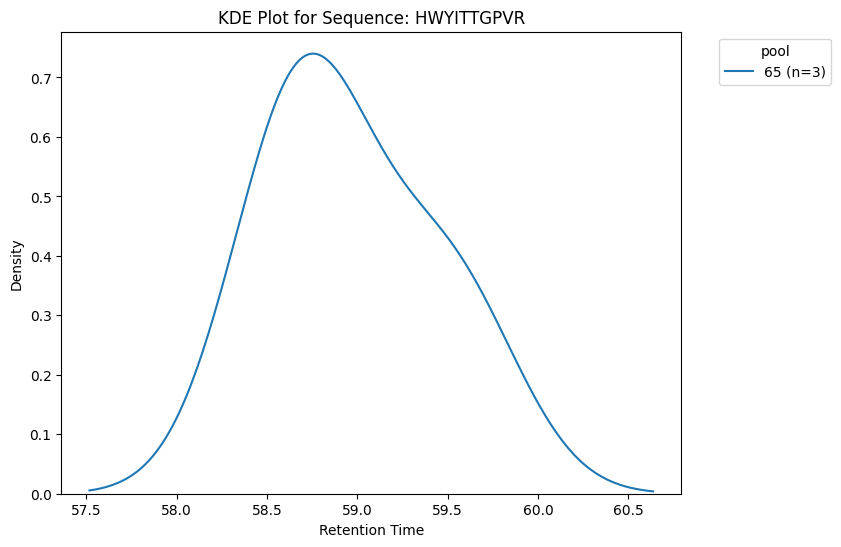

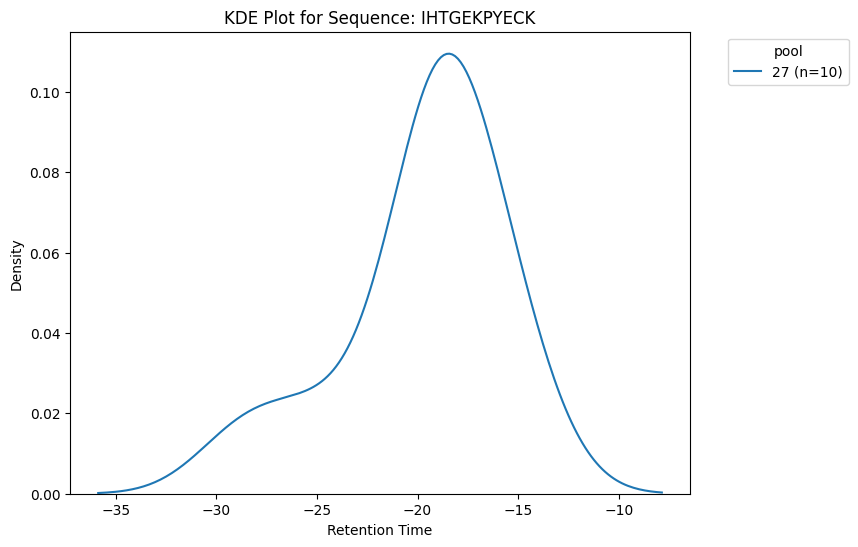

C:\Users\lambe\AppData\Local\Temp\ipykernel_11676\1892831864.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')


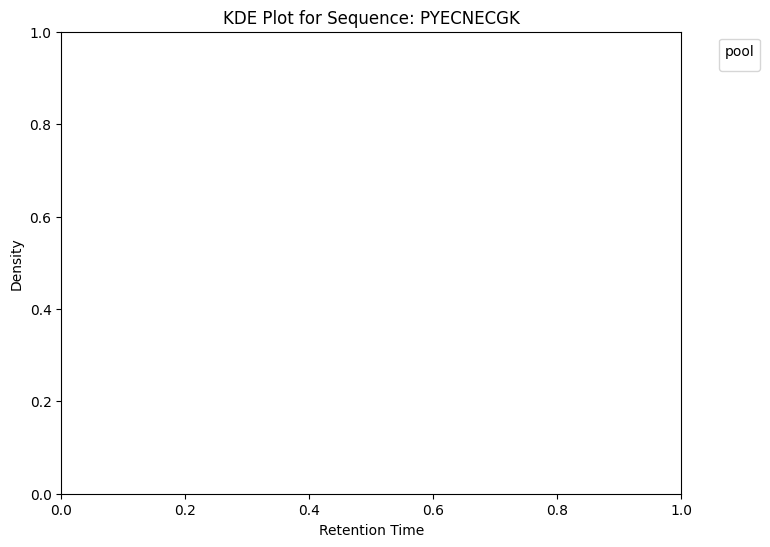

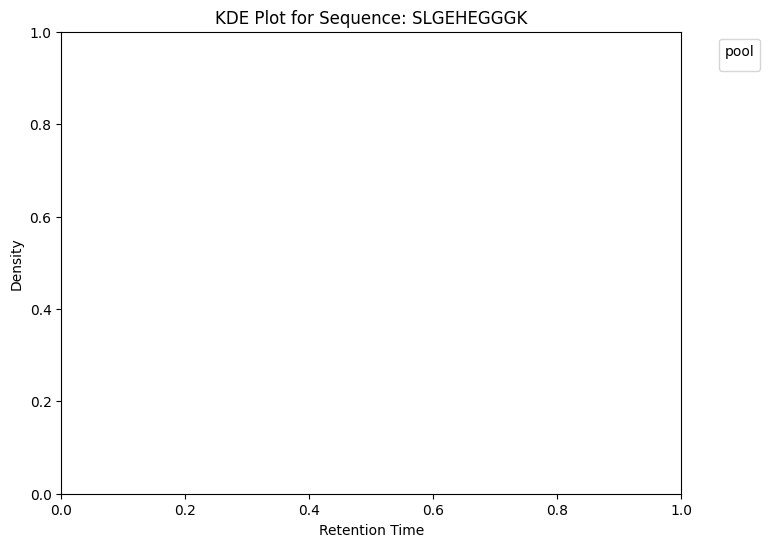

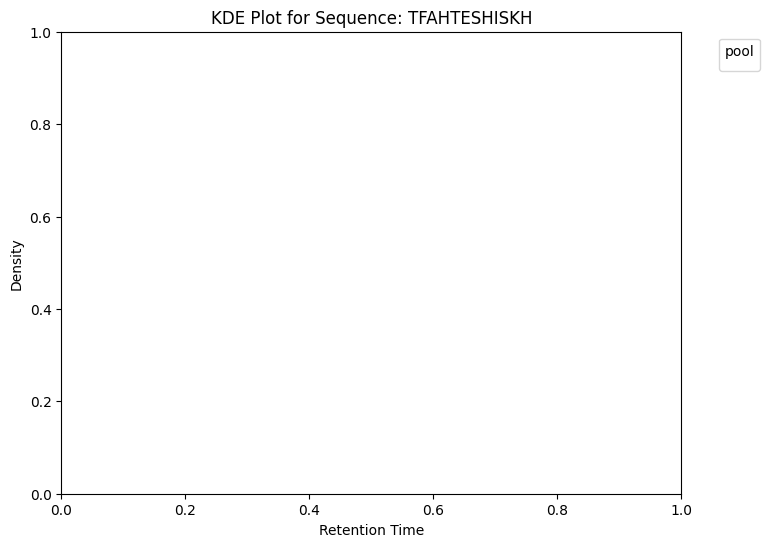

In [78]:
dic_pool = convert_dictionary_plotting(group_by_pool)
plot_kde_dictionary(dic_pool,3,"pool")